# Coordinate transformation from z levels to density levels

## Rebinning `ty_trans` to `ty_trans_rho` density levels

This transformation is commonly used for the purpose of decomposing the residual meridional overturning streamfunction into mean and eddy components. The mean is taken to be the time-mean Eulerian transport (time-mean in z coordinates), whilst the residual transport is the time-mean in density coordinates (density surface move in time). The eddy transport is the difference between the residual overturning streamfunction, and the Eulerian transport **transformed from depth to density coordinates** via the time-mean density.

Binning is the discrete version of this transformation from depth to density coordinates. We define target density bins, and for each bin we add the quantity to be binned from all cells with a density that satisfies that bin. In its simplest form, binning is creating a histogram.

We use three different binning methods:
1. `xhistogram`, which performs binning in exactly the way MOM5 does and is thus most appropriate for calculating eddy quantities (define edge of bins)
2. `xgcm` conservative binning (define edge of bins, but vertically interpolates so looks smoother than `xhistogram`)
3. Using density coordinate binning method of Lee et al. (2007) (define isopycnals to bin onto i.e. centre)

Compute times were calculated using the XXLarge (28 cpus, 128 Gb mem) Jupyter Lab on NCI's ARE, using conda environment analysis3-22.10

In [1]:
import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob
import cmocean.cm as cmocean
import xgcm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from xhistogram.xarray import histogram

from dask.distributed import Client

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34175,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:33117,Total threads: 4
Dashboard: /proxy/36673/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:36027,


In [3]:
session = cc.database.create_session()
experiment = '01deg_jra55v13_ryf9091'

rho_0 = 1035.0 # kg/m^3 reference density
g = 9.81

# reduce computation by choosing only Southern Ocean latitudes
lat_range = slice(-70, -34.99)

### Step 1: Load density and quantity being binned 
(you can choose any other quantity instead of `ty_trans`, e.g. `dzt`. Interpolate density to whatever grid that variable is on)

For the simplicity of the demonstrations here, we will **only load two months** of monthly `ty_trans`, `ty_trans_rho` and `pot_rho_2`, then take the time average after we weight with the number of days in each month.

In [4]:
start_time = '2170-01-01'
end_time = '2170-03-01'
time_slice = slice(start_time, end_time)

In [5]:
%%time
ty_trans = cc.querying.getvar(experiment, 'ty_trans', session,
                              start_time = start_time, end_time = end_time)
ty_trans = ty_trans.sel(time = time_slice).sel(yu_ocean = lat_range)

# weighted time-mean by month length
days_in_month = ty_trans.time.dt.days_in_month
total_days = days_in_month.sum()
ty_trans = (ty_trans * days_in_month).sum('time') / total_days

CPU times: user 1.04 s, sys: 307 ms, total: 1.35 s
Wall time: 7.18 s


In [6]:
%%time
pot_rho_2 = cc.querying.getvar(experiment, 'pot_rho_2', session,
                               start_time = start_time, end_time = end_time)
pot_rho_2 = pot_rho_2.sel(time = time_slice).sel(yt_ocean = lat_range)
pot_rho_2 = (pot_rho_2 * days_in_month).sum('time') / total_days

CPU times: user 1.15 s, sys: 298 ms, total: 1.45 s
Wall time: 7.99 s


In [7]:
%%time
ty_trans_rho = cc.querying.getvar(experiment, 'ty_trans_rho', session,
                                  start_time = start_time, end_time = end_time)
ty_trans_rho = ty_trans_rho.sel(time = time_slice).sel(grid_yu_ocean = lat_range)
ty_trans_rho = (ty_trans_rho * days_in_month).sum('time') / total_days

CPU times: user 1.31 s, sys: 328 ms, total: 1.64 s
Wall time: 7.82 s


Create an `xgcm` grid for interpolation, and then interpolate density onto the meridional transport grid

In [8]:
ds = xr.Dataset({'ty_trans': ty_trans, 'pot_rho_2': pot_rho_2}) 
grid = xgcm.Grid(ds, coords = {'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'}}, periodic = False)

# interpolate density (t-grid) to ty_trans grid (xt_ocean and yu_ocean)
pot_rho_2 = grid.interp(pot_rho_2, 'Y', boundary = 'extend')

## Method 1: `xhistogram`

We use `xhistogram` which is an xarray-aware method for computing histograms; see its [documentation](https://xhistogram.readthedocs.io/en/latest/).

Computation in xhistogram occurs via the same method as in MOM5 online binning. It is thus most appropriate for an comparisons between offline and online binned quantities.

### First, we define the edges of the target bins
Output will be an array with coordinate density the linear centre of these bins. If we choose `potrho_edges`, the end result will have coordinates potrho, which is the same as online binned `ty_trans_rho`.

In [9]:
targetbins = cc.querying.getvar(experiment, 'potrho_edges', session, start_time = start_time, end_time = end_time,
                                n = 1, frequency = '1 monthly').values

### Now apply the histogram over the vertical dimension `st_ocean` inside the target bins. 
We include the variable we want to bin in `weights`. This quantity should be extensive, since grid cells vary in sizes, which is true because `ty_trans` is multiplied by the cell size in x and z directions.

In [10]:
# Make sure the variables have a name, otherwise xhistogram doesn't know what to call the bins
ty_trans = ty_trans.rename('ty_trans')
pot_rho_2 = pot_rho_2.rename('pot_rho_2')

ty_trans_mean = histogram(pot_rho_2, 
                          bins = [targetbins], 
                          dim = ['st_ocean'],
                          weights = ty_trans).rename({pot_rho_2.name + '_bin': 'potrho',
                                                     'xt_ocean': 'grid_xt_ocean',
                                                     'yu_ocean': 'grid_yu_ocean'})

In [11]:
%%time
ty_trans_mean = ty_trans_mean.load()

CPU times: user 11 s, sys: 3.05 s, total: 14 s
Wall time: 27.6 s


### Now define meridional overturning streamfunctions as a cumulative sum of transport from the bottom of the ocean.

In [12]:
def cumsum_from_bottom(residual):
    cumsum = residual.cumsum('potrho') - residual.sum('potrho')
    return cumsum

In [13]:
%%time
psi_avg = cumsum_from_bottom(ty_trans_rho.sum('grid_xt_ocean') / (1e6 * rho_0)).load() # .load() since we'll use it a few times in this notebook

psi_avg_mean = cumsum_from_bottom(ty_trans_mean.sum('grid_xt_ocean') / (1e6 * rho_0))

CPU times: user 4.81 s, sys: 1.52 s, total: 6.33 s
Wall time: 6.72 s


### Plot streamfunctions of the residual, mean (what we just computed) and eddy (the difference) streamfunctions

CPU times: user 246 ms, sys: 44 ms, total: 290 ms
Wall time: 282 ms


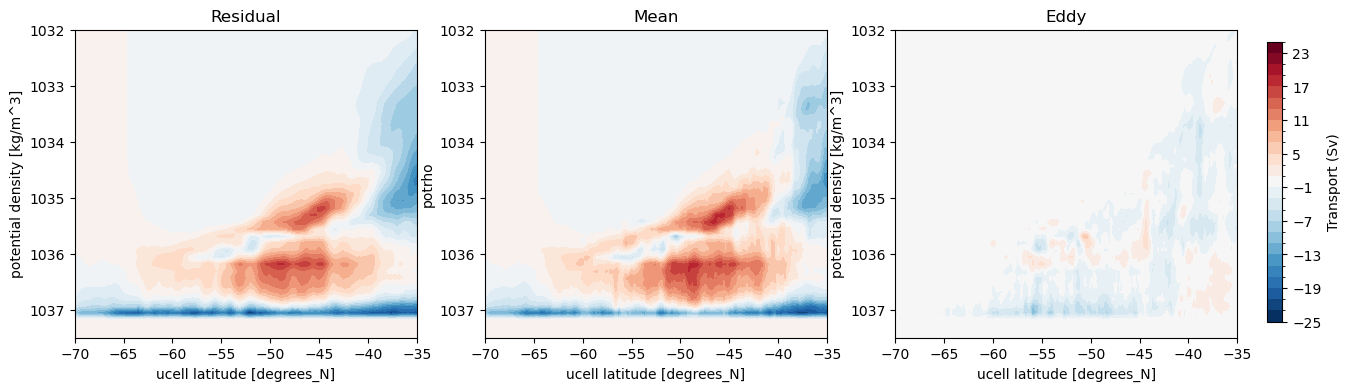

In [14]:
%%time
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))

levels = np.linspace(-25, 25, 26)

psi_avg.plot.contourf(ax = axes[0], x = 'grid_yu_ocean', levels = levels, add_colorbar = False)

psi_avg_mean.plot.contourf(ax = axes[1], x = 'grid_yu_ocean', levels = levels, add_colorbar = False)

p = (psi_avg - psi_avg_mean).plot.contourf(ax = axes[2], x = 'grid_yu_ocean', levels = levels, add_colorbar = False)

cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(p, cax=cbar_ax, label='Transport (Sv)')

axes[0].set_title('Residual')
axes[1].set_title('Mean')
axes[2].set_title('Eddy')

for ax in axes:
    ax.set_ylim(1037.5, 1032)
    ax.set_xlim(-70, -35);

## Method 2: `xgcm`

Use `xgcm`'s conservative binning, described in the [tutorial](https://xgcm.readthedocs.io/en/stable/transform.html) available in the `xgcm` [documentation](https://xgcm.readthedocs.io/en/stable).

This method results in a smoother vertical distribution than `xhistogram`, as it is not quite a histogram but does some interpolation to the top and bottom of each vertical cell. We have found that the computation currently has issues with interior land boundaries: `xgcm` isn't able to compute partial cells at the bottom of the ocean in MOM5. We thus add a correction after the computation to ensure that vertical integrals are preserved and thus that streamfunctions calculated are closed.

### Load vertical grid bin centres and edges

In [15]:
%%time

st_ocean = cc.querying.getvar(experiment, 'st_ocean', session, n=1)
st_edges_ocean = cc.querying.getvar(experiment, 'st_edges_ocean', session, n=1)

CPU times: user 2.02 s, sys: 411 ms, total: 2.43 s
Wall time: 7.56 s


### Define edge of target density bins

In [16]:
pot_rho_2_target = cc.querying.getvar(experiment, 'potrho_edges', session, start_time = start_time, end_time = end_time,
                                      n=1, frequency = '1 monthly' ).values

### Calculate vertical regridding into density coordinates

In [17]:
%%time

ds = xr.Dataset({'ty_trans': ty_trans, 'pot_rho_2': pot_rho_2})

# Note: Quantity must be extensive, e.g., ty_trans, vhrho_nt, uhrho_et, tx_trans but *not*, e.g., v, salt. 
#       If not extensive, then we need to multiply by dzt or dzu.
ds = ds.assign_coords({'st_edges_ocean': st_edges_ocean})
ds = ds.chunk({'st_edges_ocean': 76, 'st_ocean': 75}) # xgcm doesn't like it if there is more than 1 chunk in this axis

grid = xgcm.Grid(ds, coords={'Z': {'center': 'st_ocean', 'outer': 'st_edges_ocean'}}, periodic = False)
ds['pot_rho_2_outer'] = grid.interp(ds.pot_rho_2, 'Z', boundary='extend')
ds['pot_rho_2_outer'] = ds['pot_rho_2_outer'].chunk({'st_edges_ocean': 76})

ty_trans_transformed_cons = grid.transform(ds.ty_trans,
                                           'Z',
                                           pot_rho_2_target,
                                           method='conservative',
                                           target_data=ds.pot_rho_2_outer)

### change name to fit previous bins because default xgcm naming is different
# pot_rho_2_outer is actually the CENTRE of bins (I guess the convention was defined for linear interpolation not conservative)
ty_trans_transformed_cons = ty_trans_transformed_cons.rename({'pot_rho_2_outer': 'potrho'})

CPU times: user 35.1 ms, sys: 1.82 ms, total: 36.9 ms
Wall time: 34.5 ms


In [18]:
%%time
ty_trans_transformed_cons = ty_trans_transformed_cons.load()

CPU times: user 7.81 s, sys: 2.3 s, total: 10.1 s
Wall time: 13.1 s


### Now account for partial cell at bottom
We do this by finding what is missing from the vertical integral (residual). This is what was in the partial cell. We then add that residual into the densest cell that currently exists in the transformed data. This is only an approximation, because the density of the partial cell may be denser than that of the cell above it. However, this correction means the vertical integral is preserved under the transformation.

In [19]:
%%time
#find residual from vertical integral
ty_trans_residual = ty_trans.sum('st_ocean') - ty_trans_transformed_cons.sum('potrho') #this is positive definite

CPU times: user 730 ms, sys: 801 ms, total: 1.53 s
Wall time: 1.28 s


### Find bottom density of `ty_trans_transformed_cons`

In [20]:
%%time
# select out bottom values:
ty_trans_transformed_cons2 = ty_trans_transformed_cons.where(ty_trans_transformed_cons != 0) 
dens_array = ty_trans_transformed_cons2 * 0 + ty_trans_transformed_cons2.potrho # array of isopycnal value where it exists and nan elsewhere
max_dens = dens_array.max(dim = 'potrho', skipna = True)

CPU times: user 1.27 s, sys: 1.12 s, total: 2.39 s
Wall time: 2.04 s


### Add residual to this bottom density in array

In [21]:
%%time
ty_trans_residual_array = (dens_array.where(dens_array == max_dens)*0 + 1) * ty_trans_residual
ty_trans_new = ty_trans_residual_array.fillna(0)+ ty_trans_transformed_cons

CPU times: user 2.35 s, sys: 1.56 s, total: 3.91 s
Wall time: 3.29 s


In [22]:
# rename coords to match ty_trans_rho
ty_trans_new = ty_trans_new.rename({'yu_ocean': 'grid_yu_ocean', 'xt_ocean': 'grid_xt_ocean'})

In [23]:
%%time

ty_trans_new = ty_trans_new.load()

CPU times: user 8.51 s, sys: 8.99 s, total: 17.5 s
Wall time: 18.1 s


### Plot streamfunction of result

In [24]:
psi_avg_mean_2 = cumsum_from_bottom(ty_trans_new.sum('grid_xt_ocean') / (1e6 * rho_0))

CPU times: user 156 ms, sys: 18.2 ms, total: 174 ms
Wall time: 160 ms


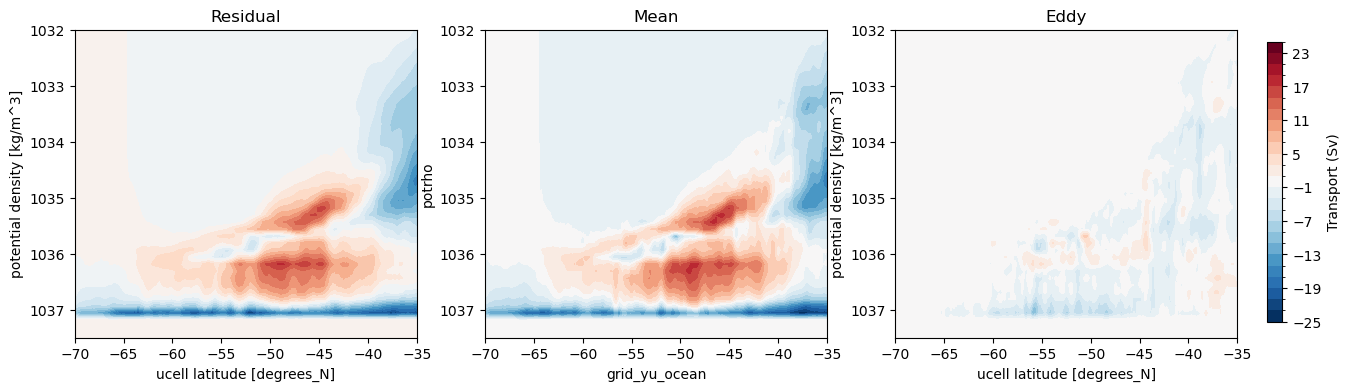

In [25]:
%%time

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))

levels = np.linspace(-25, 25, 26)

psi_avg.plot.contourf(ax = axes[0], x = 'grid_yu_ocean',levels = levels, add_colorbar = False)

psi_avg_mean_2.plot.contourf(ax = axes[1], x = 'grid_yu_ocean', levels = levels, add_colorbar = False)

p = (psi_avg - psi_avg_mean_2).plot.contourf(ax = axes[2], x = 'grid_yu_ocean', levels = levels, add_colorbar = False)

cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(p, cax=cbar_ax, label='Transport (Sv)')

axes[0].set_title('Residual')
axes[1].set_title('Mean')
axes[2].set_title('Eddy')

for ax in axes:
    ax.set_ylim(1037.5, 1032)
    ax.set_xlim(-70, -35);

## Method 3: Bin `ty_trans` (mean Eulerian overturning) into density bins

This uses the method by Lee et al. (2007) and which is is described as follows. Firstly, cells in the model output with a density $\rho$ between two prescribed densities ($\rho_\text{heavy} >\rho> \rho_\text{light}$) are selected. Each cell is assigned a proximity to the lighter density $\rho_\text{light}$, which is the 'bin fraction' $$f_b = \frac{\rho_\text{heavy}-\rho}{\rho_\text{heavy}-\rho_\text{light}}.$$

Here, a bin fraction of 1 means the cell density $\rho = \rho_\text{light}$ and $f_b=0$ means $\rho = \rho_\text{heavy}$. The quantity being binned, such as the meridional transport $vh$, is then multiplied by $f_b$ and added to the lighter density $\rho_\text{light}$ bin's meridional transport, followed by the $vh(1-f_b)$ being added to the heavier bin, $\rho_\text{heavy}$. This process is repeated for all sets of consecutive bins, meaning that density bins have input from model output cells with density slightly lower and higher than it. 

> Lee, M., Nurser, A., Coward, A., and De Cuevas, B. (2007). [Eddy advective and diffusive
transports of heat and salt in the Southern Ocean.](https://doi.org/10.1175/JPO3057.1) _Journal of Physical Oceanography_, **37(5)**, 1376–1393.

### For this method, we need to get rid of NaNs

In [26]:
ty_trans = ty_trans.fillna(0)
pot_rho_2 = pot_rho_2.fillna(0)

### Load first to reduce computation time

In [27]:
%%time
pot_rho_2 = pot_rho_2.load()
ty_trans = ty_trans.load()

CPU times: user 7.97 s, sys: 3.72 s, total: 11.7 s
Wall time: 12.5 s


In [28]:
# choose bins (in this case, default ty_trans_rho pot_rho_2 bins
rho2_bins = ty_trans_rho.potrho.values

# set up a zero array to be filled in by the algorithm
ty_trans_binned = np.zeros((len(rho2_bins), len(pot_rho_2.yu_ocean), len(pot_rho_2.xt_ocean)))

**Note**: the following cell takes a while.

In [29]:
%%time

from tqdm.auto import tqdm

# loop over the bins, performing algorithm by Lee et al. (2007)
# note that it takes time; faster if ty_trans and pot_rho_2 already loaded
for i in tqdm(range(len(rho2_bins)-1)):
    bin_mask = pot_rho_2.where(pot_rho_2 <= rho2_bins[i+1]).where(pot_rho_2 > rho2_bins[i])*0 + 1
    bin_fractions = (rho2_bins[i+1] - pot_rho_2 * bin_mask) / (rho2_bins[i+1] - rho2_bins[i])
    ## bin ty_trans:
    ty_trans_in_lower_bin = (ty_trans * bin_mask * bin_fractions).sum(dim = 'st_ocean')
    ty_trans_binned[i, :, :] += ty_trans_in_lower_bin.fillna(0).values
    del ty_trans_in_lower_bin
    ty_trans_in_upper_bin = (ty_trans * bin_mask * (1 - bin_fractions)).sum(dim = 'st_ocean')
    ty_trans_binned[i+1, :, :] += ty_trans_in_upper_bin.fillna(0).values
    del ty_trans_in_upper_bin

  0%|          | 0/79 [00:00<?, ?it/s]

CPU times: user 7min 56s, sys: 7min 59s, total: 15min 56s
Wall time: 13min 34s


In [30]:
# convert numpy array into xarray dataarray
ty_trans_binned_array = xr.DataArray(ty_trans_binned, 
                                     coords = [rho2_bins, pot_rho_2.yu_ocean, pot_rho_2.xt_ocean], 
                                     dims = ['potrho', 'grid_yu_ocean', 'grid_xt_ocean'], 
                                     name = 'ty_trans_binned')

In [31]:
# find streamfunction
psi_avg_mean_3 = cumsum_from_bottom(ty_trans_binned_array.sum('grid_xt_ocean')) / (1e6 * rho_0)

### Plot streamfunctions

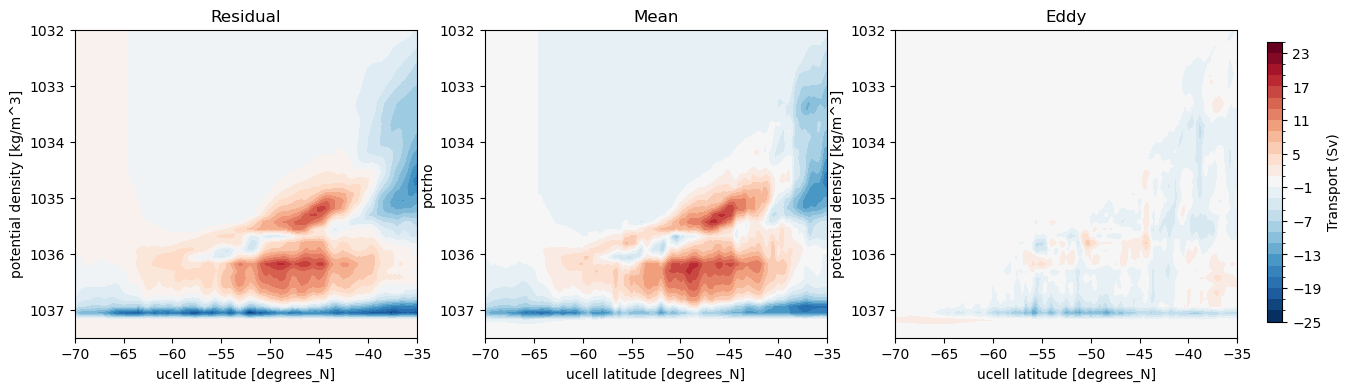

In [32]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))

levels = np.linspace(-25, 25, 26)

psi_avg.plot.contourf(ax = axes[0], x = 'grid_yu_ocean',levels = levels, add_colorbar = False)

psi_avg_mean_3.plot.contourf(ax = axes[1], x = 'grid_yu_ocean', levels = levels, add_colorbar = False)

p = (psi_avg - psi_avg_mean_3).plot.contourf(ax = axes[2], x = 'grid_yu_ocean', levels = levels, add_colorbar = False)

cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(p, cax = cbar_ax, label = 'Transport (Sv)')

axes[0].set_title('Residual')
axes[1].set_title('Mean')
axes[2].set_title('Eddy')

for ax in axes:
    ax.set_ylim(1037.5, 1032)
    ax.set_xlim(-70, -35);

### All three methods yield similar plots of the decomposition of the meridional overturning streamfunction. 

The exact numbers resulting from the transformations differ, due to the different numerical methods. `xhistogram` is exact when compared to snapshots of MOM5 model output, and is hence most appropriate when comparing between online and offline binned quantities. `xgcm` and the Lee method can still be used to compare quantities binned offline. For example, if we were to instead bin the daily transports onto isopycnals and calculate eddy terms directly from the correlation of velocity and thickness fluctuations, `xgcm` and the Lee method may be better as the weighted binning onto isopycnals leaves less chance of 'gaps' between density layers. The Lee method has no issues with partial cells, but it is **much slower** than `xgcm`.

The difference in the mean streamfunction between the three methods is presented below.

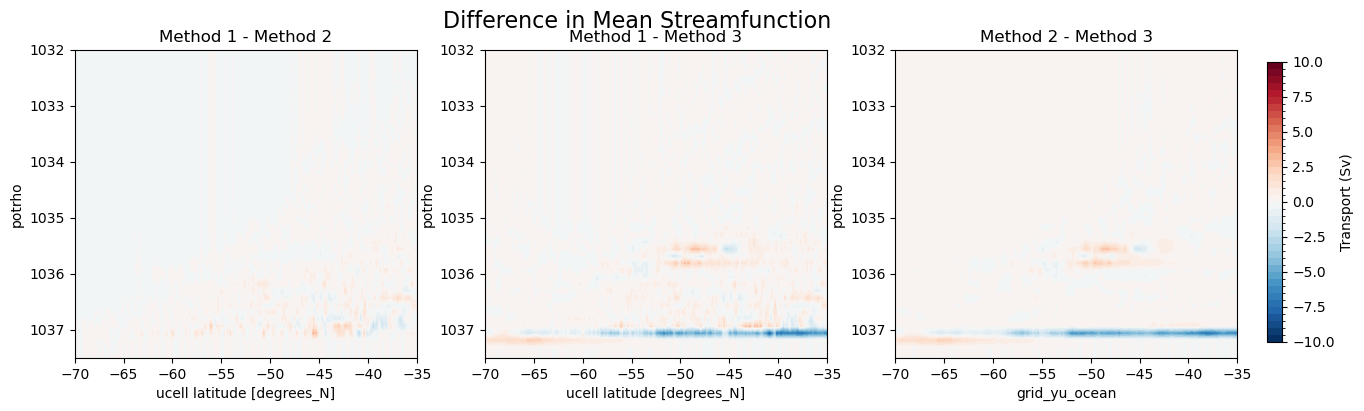

In [33]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))

levels = np.arange(-10, 10.1, 0.5)

(psi_avg_mean - psi_avg_mean_2).plot.contourf(ax = axes[0], x = 'grid_yu_ocean',levels = levels, add_colorbar = False)

(psi_avg_mean - psi_avg_mean_3).plot.contourf(ax = axes[1], x = 'grid_yu_ocean', levels = levels, add_colorbar = False)

p = (psi_avg_mean_2 - psi_avg_mean_3).plot.contourf(ax = axes[2], x = 'grid_yu_ocean', levels = levels, add_colorbar = False)

cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(p, cax=cbar_ax, label='Transport (Sv)')

axes[0].set_title('Method 1 - Method 2')
axes[1].set_title('Method 1 - Method 3')
axes[2].set_title('Method 2 - Method 3')

for ax in axes:
    ax.set_ylim(1037.5, 1032)
    ax.set_xlim(-70, -35)

fig.suptitle('Difference in Mean Streamfunction', fontsize = 16);

An alternative method to calculate the decomposition of the residual meridional overturning circulation into mean and eddy components is to bin `ty_trans` (or `vhrho_nt`) into density bins using daily data (both density and transport). Then the transport $\overline{vh}$ can be separated into a mean component $\overline{v}\overline{h}$ and an eddy component $\overline{v^\prime h^\prime}$, where the overline is a time average and primed quantities the deviation from the time average. Quantities are calculated within density layers, and $h$ is density layer thickness, calculated by binning `dzt` or `dzu`. This calculation, since it uses daily data, is computationally expensive and is difficult to do efficiently in a Jupyter notebook. The resulting streamfunctions are similar, but not identical, and may be more intuitive for isopycnal flows. An example of this method can be found at https://github.com/claireyung/Topographic_Hotspots_Upwelling-Paper_Code/blob/main/Figure_Code/Fig5-Overturning.ipynb.